
========== Đang huấn luyện XGBoost cho nồng độ: 250500 ==========
R^2: 0.9054
MAE: 0.1936
MAPE: 131.74%
RMSE: 0.2589


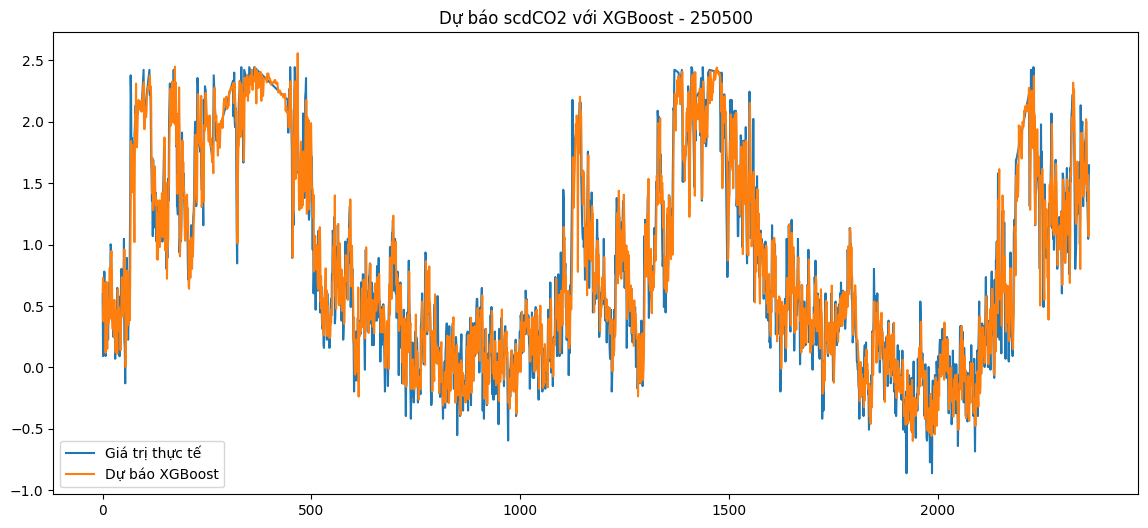


========== Đang huấn luyện XGBoost cho nồng độ: 500500 ==========
R^2: 0.9361
MAE: 0.2070
MAPE: 1043.44%
RMSE: 0.2761


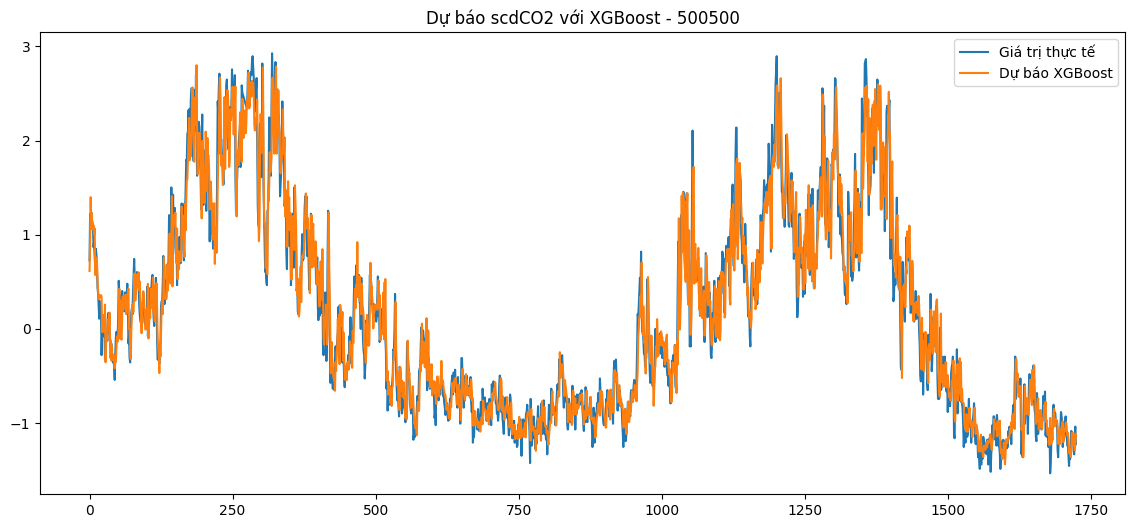


========== Đang huấn luyện XGBoost cho nồng độ: 750500 ==========
R^2: 0.9247
MAE: 0.1806
MAPE: 127.62%
RMSE: 0.2450


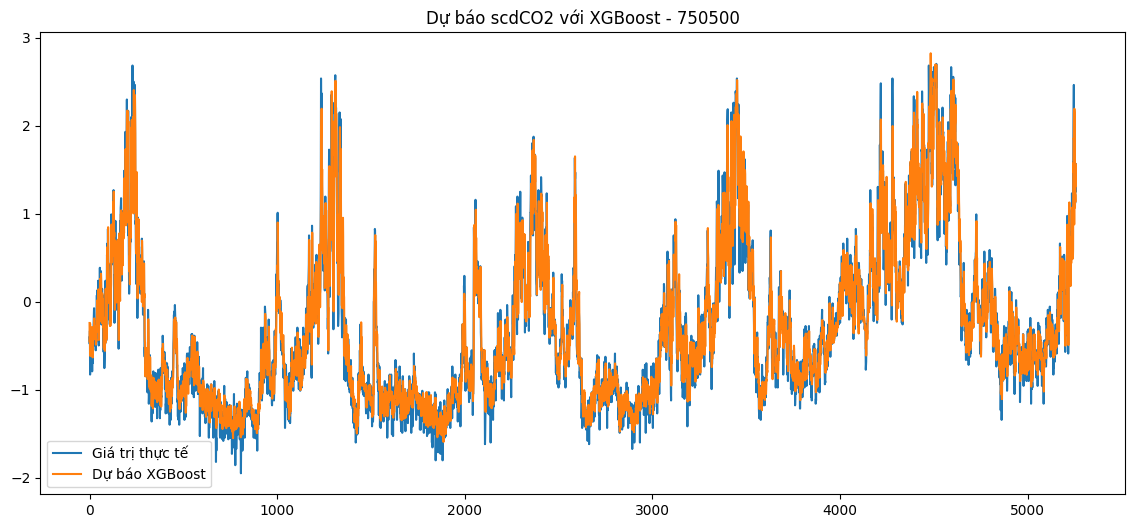


Bảng tổng hợp chỉ số các nồng độ:
  nồng độ        R2       MAE         MAPE      RMSE
0  250500  0.905370  0.193553   131.740191  0.258880
1  500500  0.936091  0.207034  1043.438313  0.276104
2  750500  0.924696  0.180638   127.616979  0.244998


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Đường dẫn dữ liệu
base_dir = r'E:\Khóa luận\Data\Phase 2'
concentration_files = {
    '250500': 'preprocessed_250500.csv',
    '500500': 'preprocessed_500500.csv',
    '750500': 'preprocessed_750500.csv'
}

target_col = 'scdCO2'  # Thay đổi nếu muốn dự báo biến khác
window_size = 24

metrics = []

for label, fname in concentration_files.items():
    print(f'\n========== Đang huấn luyện XGBoost cho nồng độ: {label} ==========')
    file_path = os.path.join(base_dir, fname)
    df = pd.read_csv(file_path)
    df['Date time'] = pd.to_datetime(df['Date time'])
    df = df.sort_values('Date time').reset_index(drop=True)

    # Tạo đặc trưng window cho XGBoost (dự báo theo chuỗi)
    values = df[target_col].values
    X, y = [], []
    for i in range(len(values) - window_size):
        X.append(values[i:i+window_size])
        y.append(values[i+window_size])
    X = np.array(X)
    y = np.array(y)

    # Chia train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Huấn luyện mô hình XGBoost
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    # Dự báo
    y_pred = model.predict(X_test)

    # Tính các chỉ số
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'R^2: {r2:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'RMSE: {rmse:.4f}')

    metrics.append({
        'nồng độ': label,
        'R2': r2,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    })

    # Vẽ biểu đồ so sánh dự báo và thực tế
    plt.figure(figsize=(14,6))
    plt.plot(y_test, label='Giá trị thực tế')
    plt.plot(y_pred, label='Dự báo XGBoost')
    plt.title(f'Dự báo {target_col} với XGBoost - {label}')
    plt.legend()
    plt.show()

# Xuất bảng tổng hợp chỉ số
metrics_df = pd.DataFrame(metrics)
print('\nBảng tổng hợp chỉ số các nồng độ:')
print(metrics_df)